# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q4: Efficient Tracking

## Q4.1: Inverse Composition (15 points)

In [ ]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], 
                  [0.0, 1.0, 0.0]])
    I = np.identity(3)

    # ===== your code here! =====

    # Create interpolators for both images
    H, W = It.shape
    x = np.arange(W)
    y = np.arange(H)
    It_spline = RectBivariateSpline(y, x, It)
    It1_spline = RectBivariateSpline(y, x, It1)

    # Create a full image meshgrid
    x_t = np.linspace(0, W-1, W)
    y_t = np.linspace(0, H-1, H)
    rectX, rectY = np.meshgrid(x_t, y_t)

    # Flatten for processing
    flat_rectX = rectX.flatten()
    flat_rectY = rectY.flatten()
    V = np.vstack([flat_rectX, flat_rectY, np.ones(flat_rectX.shape)]) # for future matrix mult: A[v1|v2|...|vn] where vi = [xi,yi,1]^T

    # Evaluate pre loop 
    # ----------------------------------------
    # T-> T(W(x;0)) = T(x)
    T = It_spline.ev(flat_rectY, flat_rectX)
    # A -> \nabla T * \particial W/ \partial p
    Ix = It_spline.ev(flat_rectY, flat_rectX, dy=1)
    Iy = It_spline.ev(flat_rectY, flat_rectX, dx=1)
    A = np.vstack([
            Ix * flat_rectX,  Ix * flat_rectY,  Ix,  
            Iy * flat_rectX,  Iy * flat_rectY,  Iy  
        ]).T  # Shape (N, 6)
    H = A.T @ A
    pre_compute = np.linalg.inv(H) @ A.T

    for i in range(num_iters):
        
        # Apply current affine transform to the points
        newV = np.dot(M, V)
        newX, newY = newV[0, :], newV[1, :]

        # Interpolate It1 at new positions
        I_warp = It1_spline.ev(newY, newX)

        # Compute error image
        b = (I_warp - T).flatten()

        # Solve for delta_p using least squares
        delta_p = pre_compute @ b 

        # Reshape delta_p into a (2,3) matrix + add last row
        delta_M = I + np.vstack([delta_p.reshape(2,3), [0,0,0]])

        # Update transformation matrix M
        M = np.dot(M, np.linalg.inv(delta_M))

        # Check for convergence
        if np.linalg.norm(delta_p) < threshold:
            break

    # plt.show()

    # ===== End of code =====
    return M

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

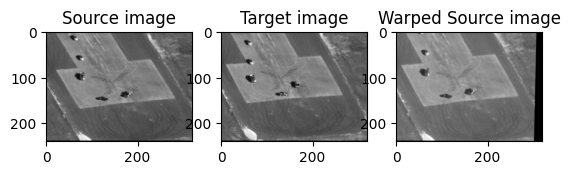

In [6]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("data/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')
plt.show()

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [ ]:
"""This a previous version which did work well for the ants, but tracked a bit to much noise for the car tracking"""

import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion_v2(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====

    # Get affine transformation matrix
    M_full = InverseCompositionAffine(It, It1, threshold, num_iters)  # (2x3) affine matrix

    # Compute the inverse affine transformation
    M_full = np.vstack([M_full, [0., 0., 1.]])  # (3x3)
    M_inv = np.linalg.inv(M_full)[:2, :]  # Take only first two rows

    # Apply affine transformation to warp `It` into `It1`'s coordinate frame
    It_warped = affine_transform(It, M_inv[:, :2], offset=M_inv[:, 2], mode='nearest')

    # Compute the binary mask
    diff = np.abs(It1 - It_warped)
    addaptive_threshold = np.mean(diff) + tolerance # depending on each frames  values
    mask0 = diff > addaptive_threshold

    # Erode and dilate
    mask1 = binary_erosion(mask0, structure=np.ones((1,1)))  # Remove noise
    mask = binary_dilation(mask1, iterations=2)              # Expand moving regions

    # ===== End of code =====

    return mask


In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====

    # Get affine transformation matrix
    M_full = InverseCompositionAffine(It, It1, threshold, num_iters)  # (2x3) affine matrix

    # Compute the inverse affine transformation
    It_warped = cv2.warpAffine(It, M_full, (It.shape[1], It.shape[0]))

    # Compute the binary mask
    diff = np.abs(It1 - It_warped)
    mask0 = diff > tolerance

    # # Erode and dilate
    mask1 = binary_erosion(mask0, structure=np.ones((1,1)))  # Remove noise
    mask = binary_dilation(mask1, iterations=2)              # Expand moving regions

    # Remove border error generated by affine transformation
    border_mask = np.zeros(It.shape, dtype=bool)
    k = int(0.05 * It.shape[0])
    border_mask[k:-k, k:-k] = True

    mask = np.logical_and(mask, border_mask)
    # ===== End of code =====
    return mask


Re-use your implementation in Q3.3 for sequence tracking.

In [8]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ===== your code here! =====
    for i in tqdm(range(1, N)):
        It1 = seq[:,:,i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)
        It = It1

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [9]:
seq = np.load("data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:21<00:00,  5.80it/s]


Ant Sequence takes 21.481746 seconds


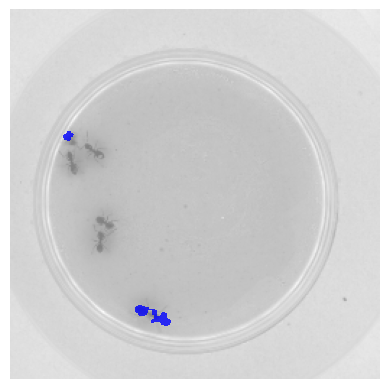

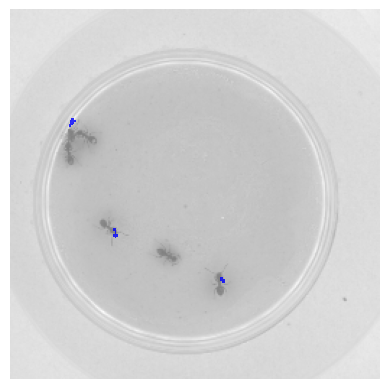

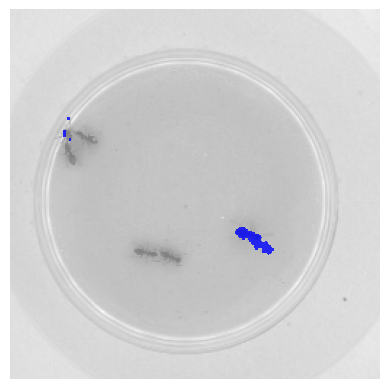

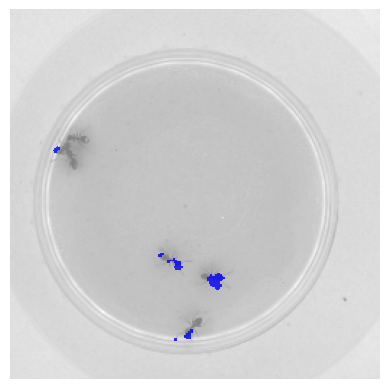

In [10]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [11]:
seq = np.load("data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\Aerial Sequence takes %f seconds' % (toc - tic))

<>:11: SyntaxWarning: invalid escape sequence '\A'
<>:11: SyntaxWarning: invalid escape sequence '\A'
C:\Users\javie\AppData\Local\Temp\ipykernel_14324\405799565.py:11: SyntaxWarning: invalid escape sequence '\A'
  print('\Aerial Sequence takes %f seconds' % (toc - tic))
100%|██████████| 149/149 [00:58<00:00,  2.55it/s]

\Aerial Sequence takes 58.560618 seconds


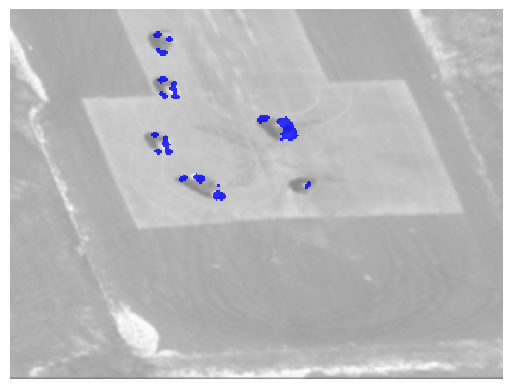

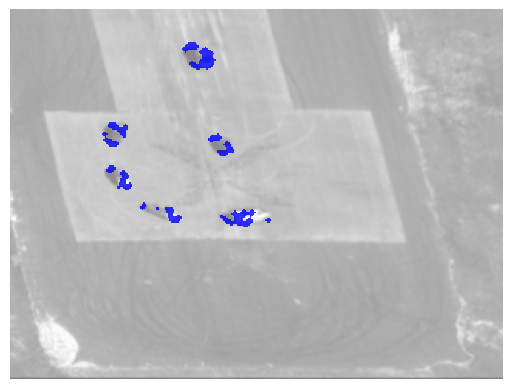

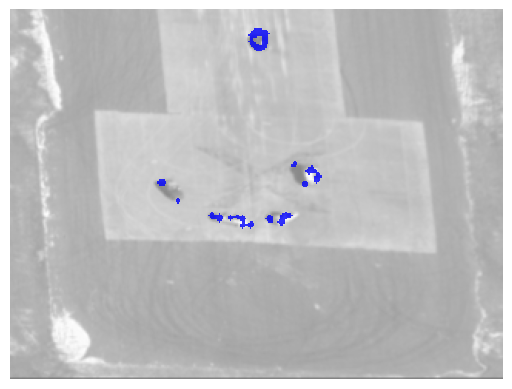

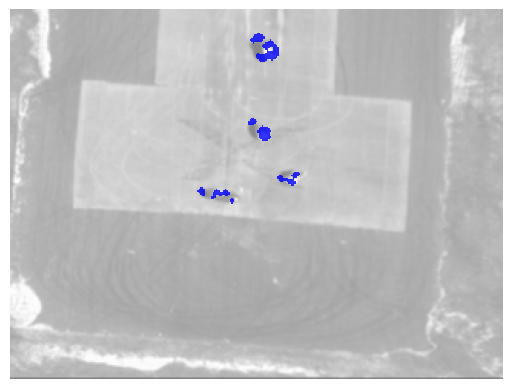

In [8]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:
===== your answer here! =====

|   | Composition | Inverse composition |
|---|-----|--------|
| Ant | 44s | 21s |
| Aerial | 103s | 58s | 

===== end of your answer ====

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:
===== your answer here! =====

The inverse compositional approach precalculates:

 1) The gradients of the image, $\nabla I$.
 2) The matrix $A := \nabla I \cdot \frac{\partial W}{\partial p}$
 3) The matrux $H := A^TA$
 4) The matrix $(A^TA)^{-1}A^T = H^{-1}A^T$: to solve the lstsq directly

thus, it only need to calculate $I(W(x,p))$ during the for loop avoiding a lot of calculations during the iterations, that means decreasing time complexity from $O(NM)$ to $O(M)$ where $M$ is the time to compute these (1) to (4) calculations, and $N$ is the number of iterations that we do during the algorithm.

===== end of your answer ====